## **Import Libraries and Functions**

In [1]:
import numpy as np
import pandas as pd
import warnings
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
from torch_geometric.nn import GAT
from torch_geometric.nn import GNNExplainer
from pyTigerGraph.gds.metrics import Accumulator, Accuracy
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (30,15)
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, roc_curve, precision_recall_curve, f1_score

def threshold_search(y_true, y_proba):
        precision , recall, thresholds = precision_recall_curve(y_true, y_proba)
        thresholds = np.append(thresholds, 1.0001) 
        F = 2 / (1/precision + 1/recall)
        best_score = np.max(F)
        best_th = thresholds[np.argmax(F)]
        return best_th 


def sample_vertex():
    for i in range(100):
        node_idx = int(np.random.choice(np.where(y_pred1==1)[0],1))
        try:
            x, edge_index = batch.x, batch.edge_index
            explainer = GNNExplainer(model, epochs=1)
            node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
            ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=batch.y)
            return node_idx
        except:
            pass
    
warnings.filterwarnings("ignore")

/opt/conda/envs/tigergraph-torch-cpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Connect to TigerGraph Database**

In [2]:
from pyTigerGraph import TigerGraphConnection

conn = TigerGraphConnection(
    host="http://3.22.188.182", # Change the address to your database server's
    graphname="Ethereum"
)

#conn.getToken(conn.createSecret()) # Use if your database has authentication enabled

## **Add Degree Features inside TigerGraph**

In [3]:
f = conn.gds.featurizer()

f.installAlgorithm("degrees", query_path="./gsql/degrees.gsql")

'degrees'

In [4]:
f.runAlgorithm("degrees", custom_query=True)

Default parameters are: None


[{'"Success !"': 'Success !'}]

## **Add Amounts Features inside TigerGraph**

In [5]:
f.installAlgorithm("amounts", query_path="./gsql/amounts.gsql")

'amounts'

In [6]:
f.runAlgorithm("amounts", custom_query=True)

Default parameters are: None


[{'"Success!"': 'Success!'}]

## **Downsample the data**

In [7]:
f.installAlgorithm("downsample", query_path="./gsql/downsample.gsql")

f.runAlgorithm("downsample", custom_query=True)

Default parameters are: None


[{'"Success!"': 'Success!'}]

## **Check Count of Positive Labels**

In [8]:
conn.getVertexCount("Account","is_fraud = 1")

1165

## **Check Count of Negative Labels**

In [9]:
conn.getVertexCount("Account","is_fraud = 0")

25936

## **Run Train-Test Split inside TigerGraph**

In [10]:
%%time
split = conn.gds.vertexSplitter(is_training=0.8, is_validation=0.2)
split.run()

Splitting vertices...
Vertex split finished successfully.
CPU times: user 32.3 ms, sys: 3.94 ms, total: 36.2 ms
Wall time: 1.1 s


## **Add PageRank Features inside TigerGraph**

In [11]:
feat = conn.gds.featurizer()
feat.installAlgorithm("tg_pagerank")
tg_pagerank_params = {
  "v_type": "Account",
  "e_type": "Transaction",
  "result_attr": "pagerank",
  "top_k":5  
}
results = pd.json_normalize(feat.runAlgorithm("tg_pagerank",tg_pagerank_params)[0]['@@top_scores_heap'])
results

,Vertex_ID,score
0,0x3cbd2e6143f057bd49ffb4c7058217a5900c35d3,261.47763
1,0xbfa82fbe0e66d8e2b7dcc16328db9ecd70533d13,179.41733
2,0x5df65e16d6ec1a8090ffa11c8185ad372a8786cd,146.79134
3,0xea3a8bd1a99e16160832d6b473ce06c1058dff7e,60.74960
4,0x903bb9cd3a276d8f18fa6efed49b9bc52ccf06e5,58.86850


## **Add Hyperparameters for NeighborSampler and Graph Neural Network**

In [12]:
# Hyperparameters
hp = {"batch_size": 5000, "num_neighbors": 200, "num_hops": 3, "hidden_dim": 128, "num_layers": 2, "dropout": 0.05, "lr": 0.0075, "l2_penalty": 5e-5}

## **Define Train Neighbor Loader using TigerGraph**

Output is provided directly in PyTorch Geometric Format

In [13]:
train_loader = conn.gds.neighborLoader(
    v_in_feats=["in_degree","out_degree","send_amount","send_min","recv_amount","recv_min","pagerank"],
    v_out_labels=["is_fraud"],
    v_extra_feats=["is_training", "is_validation"],
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    filter_by = "is_training",
    shuffle=True,
    timeout=600000
)

## **Define Validation Neighbor Loader using TigerGraph**

Output is provided directly in PyTorch Geometric Format

In [14]:
valid_loader = conn.gds.neighborLoader(
    v_in_feats=["in_degree","out_degree","send_amount","send_min","recv_amount","recv_min","pagerank"],
    v_out_labels=["is_fraud"],
    v_extra_feats=["is_validation", "is_training"],
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    filter_by = "is_validation",
    shuffle=True,
    timeout=600000
)

## **Define Graph Attention Network Architecture using PyTorch Geometric**

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GAT(
    in_channels=7,
    hidden_channels=hp["hidden_dim"],
    num_layers=hp["num_layers"],
    out_channels=2,
    heads=8,
    dropout=hp["dropout"],
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(), lr=hp["lr"], weight_decay=hp["l2_penalty"]
)

## **Run Training Loop with AUC, AUCPR, Precision and Recall as Metrics**

In [16]:
global_steps = 0
logs = {}
for epoch in range(10):
    # Train
    print("Start Training epoch:", epoch)
    model.train()
    epoch_train_loss = Accumulator()
    
    epoch_train_auc = []
    epoch_train_prec = []
    epoch_train_rec = []
    epoch_train_apr = []
    epoch_best_thr = []
    
    # Iterate through the loader to get a stream of subgraphs instead of the whole graph
    for bid, batch in enumerate(train_loader):
        # print(bid, batch)
        batchsize = batch.x.shape[0]
        norm = T.NormalizeFeatures()
        batch = norm(batch).to(device)
        batch.x = batch.x.type(torch.FloatTensor)
        batch.y = batch.y.type(torch.LongTensor)
       
        # Forward pass
        out = model(batch.x, batch.edge_index, batch.edge_weight)
        # Calculate loss
        class_weight = torch.FloatTensor([1.0, 15.0])
        loss = F.cross_entropy(out[batch.is_training], batch.y[batch.is_training], class_weight)
        # f1_loss(batch.y[batch.is_training], out[batch.is_training], is_training=True)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss.update(loss.item() * batchsize, batchsize)
        # Predict on training data
        with torch.no_grad():
            pred = out.argmax(dim=1)
            y_pred = out[batch.is_training][:,1].cpu().numpy()
            y_true = batch.y[batch.is_training].cpu().numpy()
            # softmax = F.softmax(out, dim=1)[batch.is_training][:,1].cpu().numpy()
            best_threshold = threshold_search(y_true, y_pred)
            y_pred1 = (y_pred > best_threshold).astype(int)

            try:
                epoch_train_auc.append(roc_auc_score(y_true, y_pred))
            except:
                epoch_train_auc.append(np.NaN)
                
            epoch_train_prec.append(precision_score(y_true, y_pred1))
            epoch_train_rec.append(recall_score(y_true, y_pred1))
            epoch_train_apr.append(average_precision_score(y_true, y_pred))
            epoch_best_thr.append(best_threshold)
            
        # Log training status after each batch
        logs["loss"] = epoch_train_loss.mean
        logs["auc"] = np.mean(epoch_train_auc)
        logs["prec"] = np.mean(epoch_train_prec)
        logs["rec"] = np.mean(epoch_train_rec)
        logs["apr"] = np.mean(epoch_train_apr)
        logs["thr"] = np.mean(epoch_best_thr)
        
        print(
            "Epoch {}, Train Batch {}, Loss {:.4f}, AUC {:.4f}, AUCPR {:.4f}, Precision {:.4f}, Recall {:.4f}".format(
                epoch, bid, logs["loss"], logs["auc"], logs["apr"], logs["prec"], logs["rec"]
            )
        )
        global_steps += 1
    # Evaluate
    print("Start validation epoch:", epoch)
    model.eval()
    epoch_val_loss = Accumulator()
    epoch_val_prec = []
    epoch_val_rec = []
    epoch_val_auc = []
    epoch_val_apr = []
    
    for batch in valid_loader:
        batchsize = batch.x.shape[0]
        norm = T.NormalizeFeatures()
        batch = norm(batch).to(device)
        with torch.no_grad():
            # Forward pass
            batch.x = batch.x.type(torch.FloatTensor)
            batch.y = batch.y.type(torch.LongTensor)
            out = model(batch.x, batch.edge_index)   
            # Calculate loss
            class_weight = torch.FloatTensor([1.0, 20.0])
            valid_loss = F.cross_entropy(out[batch.is_validation], batch.y[batch.is_validation], class_weight)
            # f1_loss(batch.y[batch.is_validation], out[batch.is_validation])
            epoch_val_loss.update(valid_loss.item() * batchsize, batchsize)
            # Prediction
            pred = out.argmax(dim=1)
            y_pred = out[batch.is_validation][:,1].cpu().numpy()
            y_true = batch.y[batch.is_validation].cpu().numpy()
            # softmax = F.softmax(out, dim=1)[batch.is_validation][:,1].cpu().numpy()
            y_pred1 = (y_pred > np.mean(epoch_best_thr)).astype(int)
            
            try:
                epoch_val_auc.append(roc_auc_score(y_true, y_pred))
            except:
                epoch_val_auc.append(np.NaN)
            epoch_val_prec.append(precision_score(y_true, y_pred1))
            epoch_val_rec.append(recall_score(y_true, y_pred1))
            epoch_val_apr.append(average_precision_score(y_true, y_pred))

    # Log testing result after each epoch
    logs["val_loss"] = epoch_val_loss.mean
    logs["val_prec"] = np.mean(epoch_val_prec)
    logs["val_auc"] = np.mean(epoch_val_auc)
    logs["val_rec"] = np.mean(epoch_val_rec)
    logs["val_apr"] = np.mean(epoch_val_apr)
    print(
        "Epoch {}, Valid Loss {:.4f}, Valid AUC {:.4f}, Valid AUCPR {:.4f}, Valid Precision {:.4f}, Valid Recall {:.4f}".format(
            epoch, logs["val_loss"], logs["val_auc"], logs["val_apr"], logs["val_prec"], logs["val_rec"]
        )
    )


Start Training epoch: 0
Epoch 0, Train Batch 0, Loss 0.6975, AUC 0.6370, AUCPR 0.1116, Precision 0.1232, Recall 0.5871
Epoch 0, Train Batch 1, Loss 0.6901, AUC 0.6481, AUCPR 0.1157, Precision 0.1277, Recall 0.5961
Epoch 0, Train Batch 2, Loss 0.6832, AUC 0.6609, AUCPR 0.1234, Precision 0.1408, Recall 0.5789
Epoch 0, Train Batch 3, Loss 0.6781, AUC 0.6712, AUCPR 0.1292, Precision 0.1497, Recall 0.5675
Epoch 0, Train Batch 4, Loss 0.6747, AUC 0.6778, AUCPR 0.1311, Precision 0.1539, Recall 0.5701
Start validation epoch: 0
Epoch 0, Valid Loss 0.6918, Valid AUC 0.6766, Valid AUCPR 0.0811, Valid Precision 0.0696, Valid Recall 0.8737
Start Training epoch: 1
Epoch 1, Train Batch 0, Loss 0.6635, AUC 0.6718, AUCPR 0.1253, Precision 0.1482, Recall 0.5995
Epoch 1, Train Batch 1, Loss 0.6545, AUC 0.6861, AUCPR 0.1337, Precision 0.1639, Recall 0.5713
Epoch 1, Train Batch 2, Loss 0.6525, AUC 0.6879, AUCPR 0.1338, Precision 0.1623, Recall 0.5901
Epoch 1, Train Batch 3, Loss 0.6492, AUC 0.6905, AUCPR 0

## **Define and Run Explainability Model**
This samples a random vertex that was predicted to be fraudulent and visualizes the subgraph around it.

Explain node 1891: 100%|██████████| 100/100 [00:00<00:00, 265.29it/s]


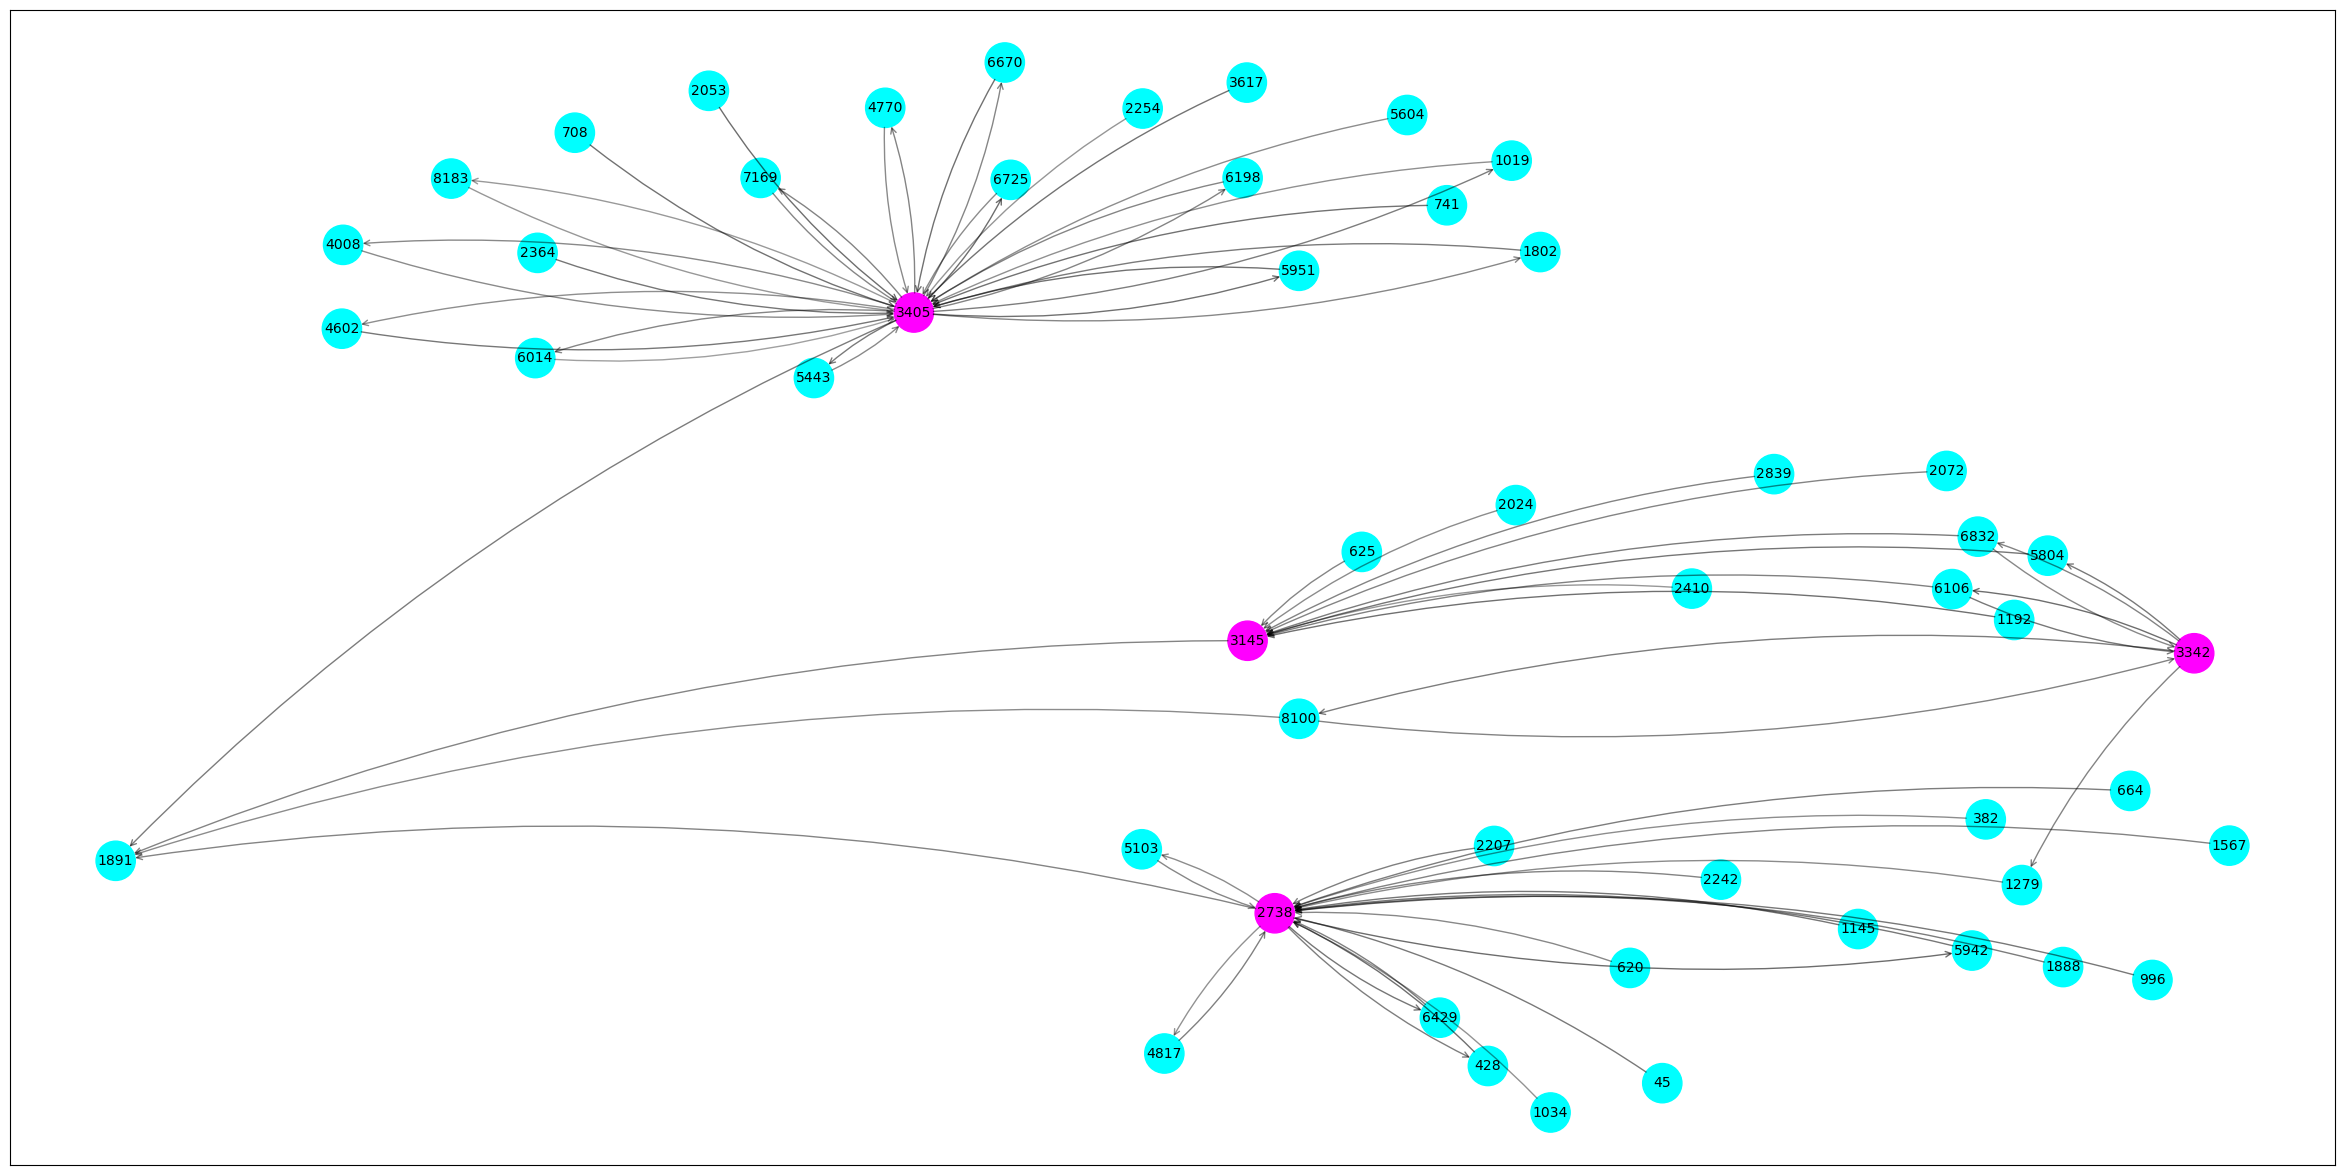

In [57]:
node_idx = sample_vertex()  #2726
x, edge_index = batch.x, batch.edge_index

explainer = GNNExplainer(model, epochs=100)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

## **Show Local Feature Importance**
Using the sampled vertex from above, view the features that contributed the most to the fraudulent prediction.

Explain node 3405: 100%|██████████| 100/100 [00:00<00:00, 287.17it/s]

---- Normalized Feature Importance
 


,in_degree,out_degree,send_amount,send_min,recv_amount,recv_min,pagerank
Account ID,,,,,,,
1891,0.771100,0.254433,0.738624,0.264987,0.720286,0.267881,0.259701
3145 (3145),0.744347,0.298169,0.758824,0.268933,0.794020,0.286645,0.267405
2738 (2738),0.759875,0.282628,0.730018,0.272793,0.768702,0.294467,0.240950
8100 (8100),0.747731,0.240385,0.738613,0.254362,0.746735,0.295353,0.247961
3405 (3405),0.706239,0.268900,0.767393,0.288227,0.764875,0.244750,0.266708


---- Normalized Feature Values
 


,in_degree,out_degree,send_amount,send_min,recv_amount,recv_min,pagerank
3145,0.119895,0.110673,0.351576,0.000000,0.400523,0.000461,0.016872
2738,0.261699,0.207973,0.133126,0.000000,0.362953,0.000021,0.034228
8100,0.285356,0.342428,0.160682,0.000083,0.179082,0.000163,0.032206
3405,0.154719,0.042329,0.531244,0.000000,0.242570,0.000000,0.029139
1891,0.193614,0.000000,0.000000,0.000000,0.773794,0.000323,0.032269


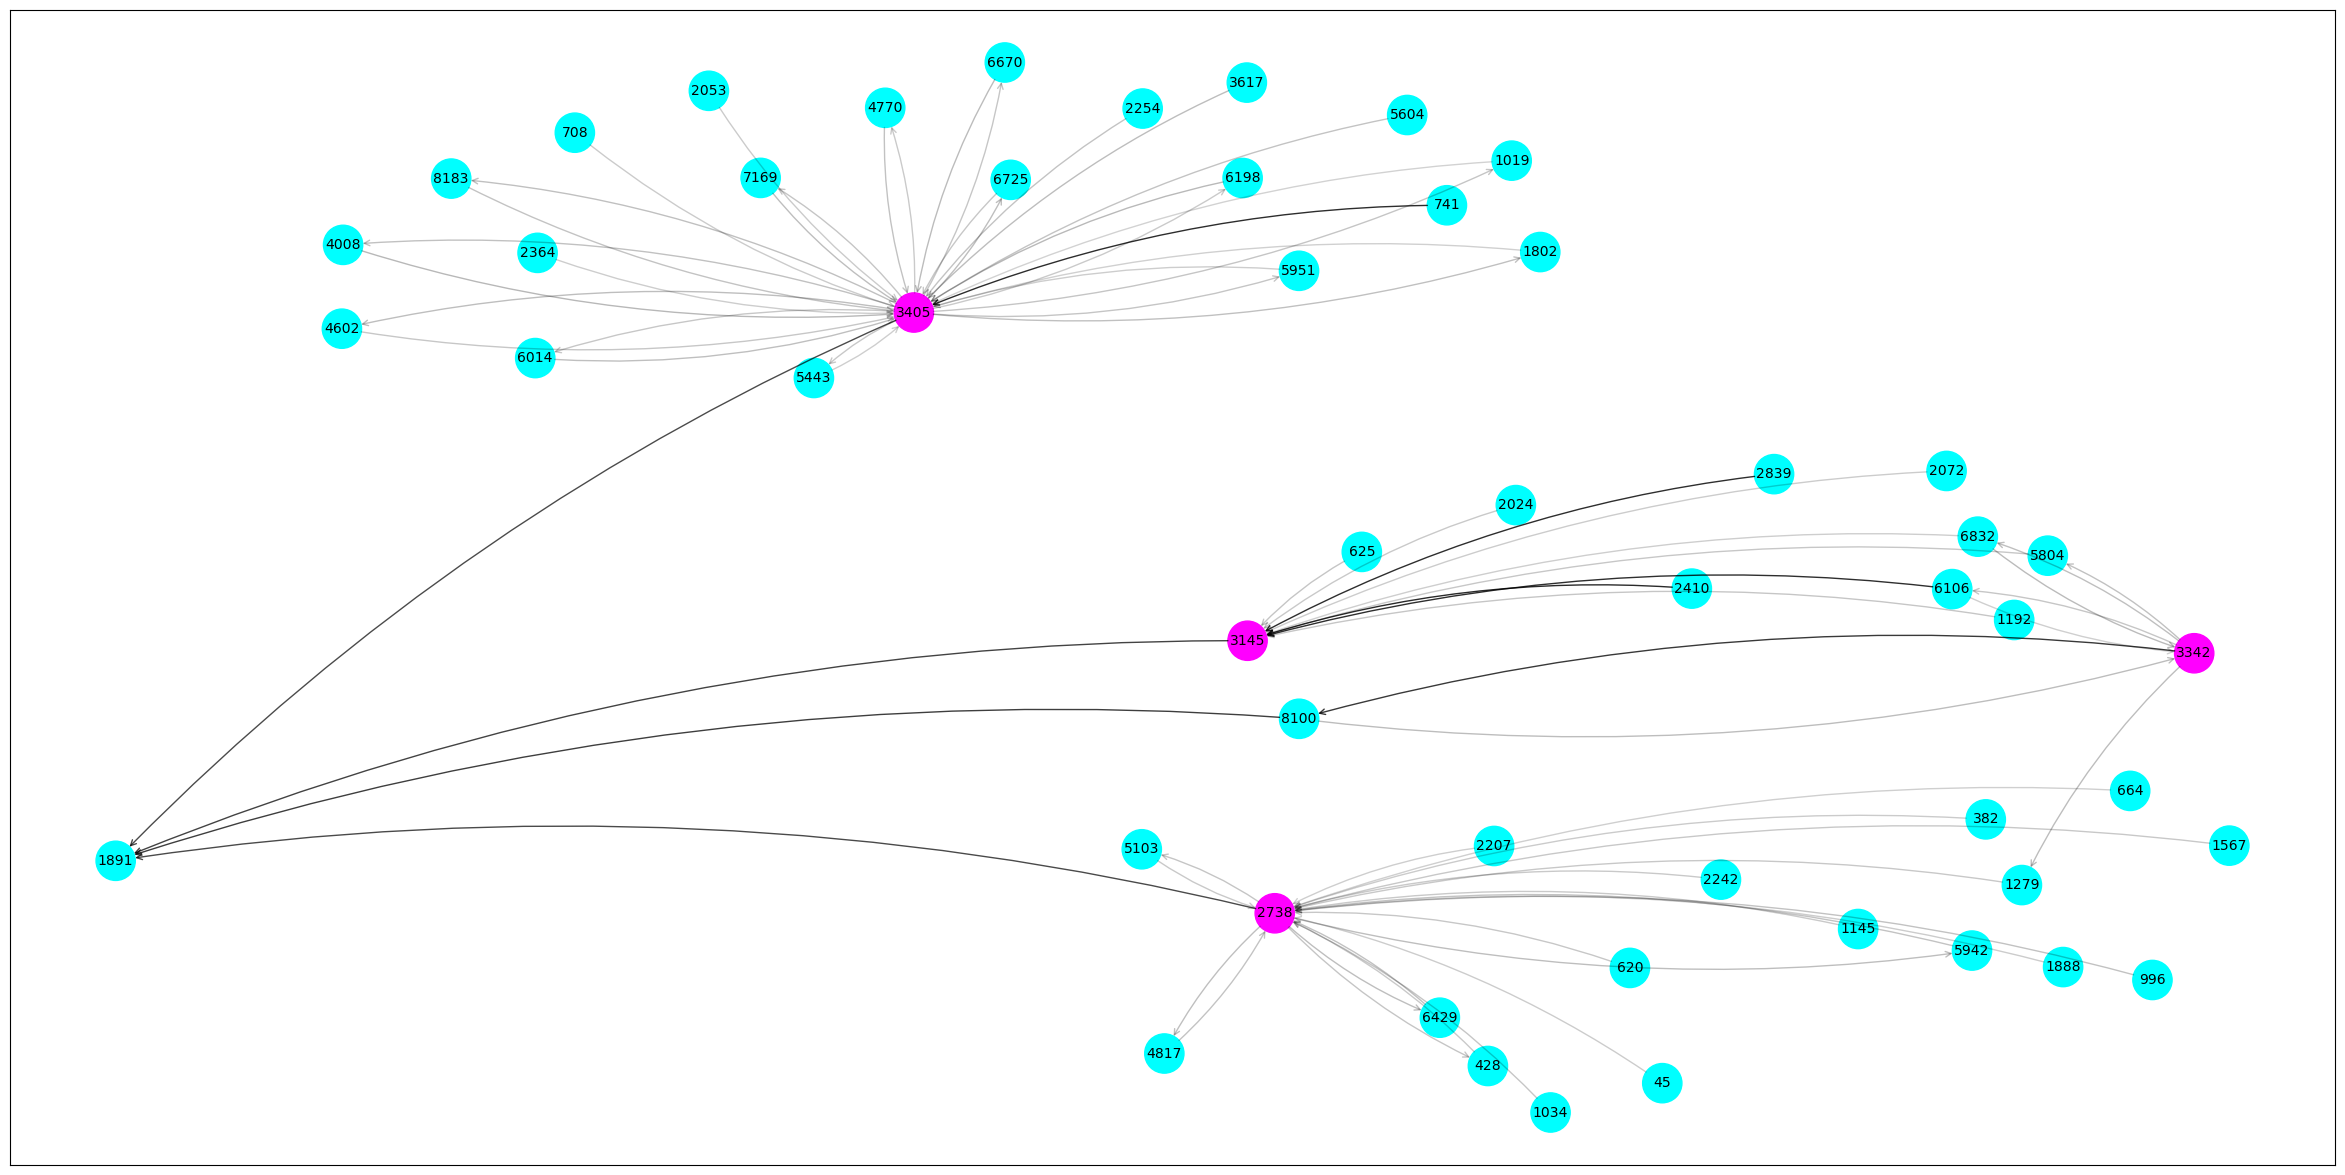

In [58]:
import pandas as pd
from IPython.display import display

ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y = batch.y)
feature_values = list()
feature_values.append(["{}".format(node_idx)] + node_feat_mask.tolist())  # Center ID
important_accounts = set()
for src, dst, attr in G.edges(data=True):
    edge_importance = attr["att"]
    if edge_importance >= 0.001:
        if src == node_idx:
            important_accounts.add(dst)
        elif dst == node_idx:
            important_accounts.add(src)

subg_accts = list(important_accounts)
subg_accts.append(node_idx)
for acct_idx in important_accounts:
    target_id = acct_idx
    node_feat_mask, _ = explainer.explain_node(acct_idx, x, edge_index)
    feature_values.append(["{} ({})".format(target_id, acct_idx)] + node_feat_mask.tolist())
feature_names = ['in_degree', 'out_degree', 'send_amount', 'send_min', 'recv_amount', 'recv_min', 'pagerank']
df = pd.DataFrame(feature_values, columns=["Account ID"] + feature_names).set_index("Account ID")
print("---- Normalized Feature Importance")
print(" ")
display(df.style.background_gradient(axis=1))
print("---- Normalized Feature Values")
print(" ")
feature_df = pd.DataFrame(batch.x.cpu().numpy(), columns = feature_names)
display(feature_df.loc[subg_accts])